In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
import model
from model_loader import ModelLoader

In [3]:
# wd = os.path.dirname(os.path.abspath('__file__'))
# weights = os.path.join(wd, 'best.pt')
weights = '/Users/hping/Downloads/best.pt'
print(weights)

/Users/hping/Downloads/best.pt


# Test Model Loader

In [4]:
ml = ModelLoader(model_file=weights)

# Sample Some Labeled Data

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

You will get two different datasets:

 1. an unlabeled dataset for pre-training
 2. a labeled dataset for both training and validation
 
## The dataset is organized into three levels: scene, sample and image

 1. A scene is 25 seconds of a car's journey.
 2. A sample is a snapshot of a scene at a given timeframe. Each scene will be divided into 126 samples, so about 0.2 seconds between consecutive samples.
 3. Each sample contains 6 images captured by camera facing different orientation.
    Each camera will capture 70 degree view. To make it simple, you can safely assume that the angle between the cameras is 60 degrees 

106 scenes in the unlabeled dataset and 28 scenes in the labeled dataset

In [6]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [7]:
# project_folder = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
# provided_folder = os.path.join(project_folder,'Provided_Info')
provided_folder = '/Users/hping/prince/'
image_folder = os.path.join(provided_folder,'data')
annotation_csv = os.path.join(image_folder,'annotation.csv')
print(image_folder)

/Users/hping/prince/data


In [27]:
transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset,
                                          batch_size=2,
                                          shuffle=True,
                                          collate_fn=collate_fn)

In [30]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


In [31]:
pred_boxes = ml.get_bounding_boxes(sample)
pred_roads = ml.get_binary_road_map(sample)

In [58]:
pred_boxes.shape

torch.Size([2, 100, 2, 4])

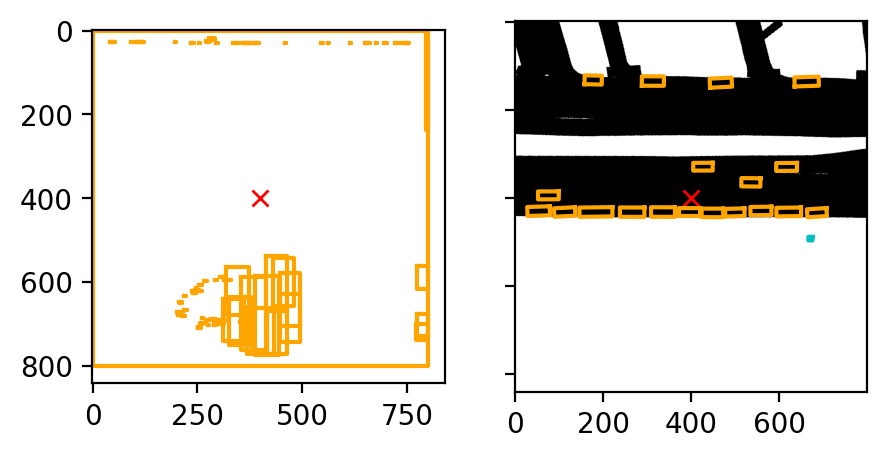

In [48]:
ith = 1

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.imshow(pred_roads[ith], cmap ='binary');

# The ego car position
ax1.plot(400, 400, 'x', color="red")

corners = pred_boxes[ith]
for i, bb in enumerate(corners):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax1, bb.detach(), color='orange') 

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax2.imshow(road_image[ith], cmap ='binary');

# The ego car position
ax2.plot(400, 400, 'x', color="red")

corners = target[ith]['bounding_box']
for i, bb in enumerate(corners):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax2, bb, color=color_list[target[ith]['category'][i]]) 

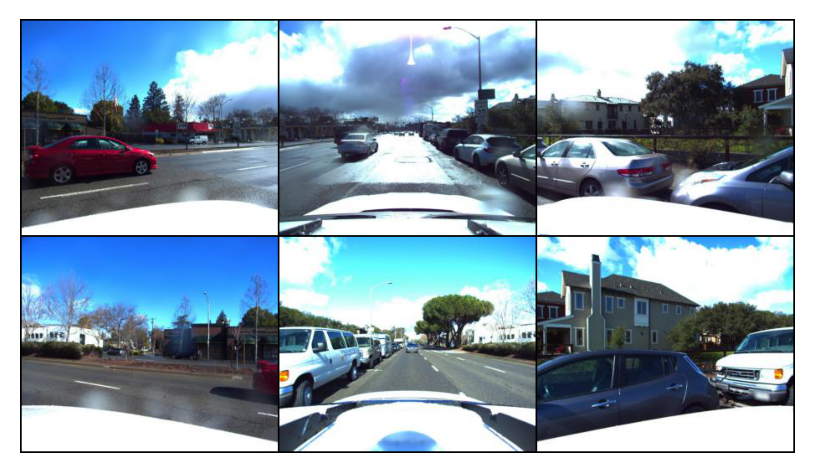

In [59]:
# The 6 images orgenized in the following order:
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[ith], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');